# 第4章　パーセプトロン：分類アルゴリズムの基礎

## 4.1 確率的勾配降下法のアルゴリズム

**[04PT-01]**

必要なモジュールをインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal

import matplotlib
matplotlib.rcParams['font.size'] = 12

**[04PT-02]**

トレーニングセットのデータを生成する関数を用意します。

平面上の ○ ☓ の 2 種類のデータについて、それぞれの「個数、中心座標、分散」を引数で指定します。

In [2]:
def prepare_dataset(n1, mu1, variance1, n2, mu2, variance2):
  df1 = DataFrame(multivariate_normal(mu1, np.eye(2)*variance1 ,n1),
                  columns=['x', 'y'])
  df1['type'] = 1
  df2 = DataFrame(multivariate_normal(mu2, np.eye(2)*variance2, n2),
                  columns=['x', 'y'])
  df2['type'] = -1
  df = pd.concat([df1, df2], ignore_index=True)
  df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
  return df

**[04PT-03]**

トレーニングセットのデータを生成して、先頭から10個分のデータをサンプルとして表示します。

`type` の値がデータの種類 $t=\pm 1$ に対応します。

In [3]:
train_set = prepare_dataset(20, [15, 10], 15, 30, [0, 0], 15)
train_set[:10]

,x,y,type
0,-4.004508,-2.806351,-1
1,6.101915,13.927351,1
2,-5.920302,-3.125469,-1
3,15.992586,1.246831,1
4,3.169914,0.141364,-1
5,-2.817974,2.664669,-1
6,-0.307768,-2.689198,-1
7,15.090948,13.269696,1
8,-2.103559,-0.993524,-1
9,9.764678,12.894031,1


**[04PT-05]**

パーセプトロンによる分類を実施する関数を用意します。

生成したトレーニングセットを引数に渡すと、「$n=1\sim N$ のデータをチェックしながらパラメーターを修正する」という処理を 30 回繰り返した後に、この間のパラメーターの変化を記録したリストと最終的な誤分類率（正しく分類されていないデータの割合）を返します。

In [4]:
def run_train(train_set):
  # パラメータの初期値とbias項の設定
  w0 = w1 = w2 = 0.0
  bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())

  # Iterationを実施
  paramhist = DataFrame([[w0, w1, w2]], columns=['w0', 'w1', 'w2'])
  for i in range(30):
    for index, point in train_set.iterrows():
      x, y, type = point.x, point.y, point.type
      if (w0*bias + w1*x + w2*y) * type <= 0:
        w0 += type * bias
        w1 += type * x
        w2 += type * y
    paramhist = paramhist.append({'w0': w0, 'w1': w1, 'w2': w2},
                                 ignore_index=True)

  # 判定誤差の計算
  err = 0.0
  for index, point in train_set.iterrows():
    x, y, type = point.x, point.y, point.type
    if (w0*bias + w1*x + w2*y) * type <= 0:
      err += 1
  err_rate = err * 100 / len(train_set)

  return paramhist, err_rate

**[04PT-06]**

学習処理を実行します。

In [5]:
paramhist, err_rate = run_train(train_set)

**[04PT-07]**

分類結果をグラフに可視化する関数を用意します。

In [6]:
# 結果の表示
def show_result(subplot, train_set, w0, w1, w2, err_rate):
  train_set1 = train_set[train_set['type']==1]
  train_set2 = train_set[train_set['type']==-1]
  bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())
  ymin, ymax = train_set.y.min()-5, train_set.y.max()+10
  xmin, xmax = train_set.x.min()-5, train_set.x.max()+10

  subplot.set_ylim([ymin-1, ymax+1])
  subplot.set_xlim([xmin-1, xmax+1])
  subplot.scatter(train_set1.x, train_set1.y, marker='o', label=None)
  subplot.scatter(train_set2.x, train_set2.y, marker='x', label=None)

  linex = np.arange(xmin-5, xmax+5)
  liney = - linex * w1 / w2 - bias * w0 / w2
  label = "ERR %.2f%%" % err_rate
  subplot.plot(linex, liney, label=label, color='red')
  subplot.legend(loc=1, fontsize=14)

**[04PT-08]**

分類結果をグラフに表示します。

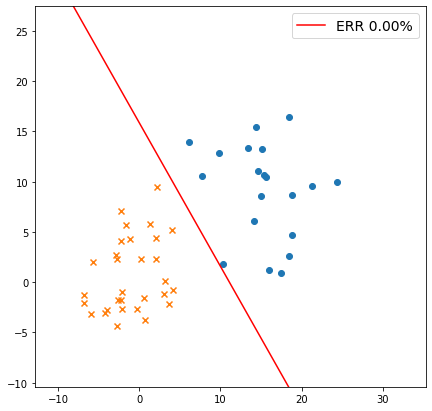

In [7]:
fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
params = paramhist[-1:]
w0, w1, w2 = float(params.w0), float(params.w1), float(params.w2)
show_result(subplot, train_set, w0, w1, w2, err_rate)

**[04PT-09]**

同じく、パラメーターの変化をグラフに表示します。

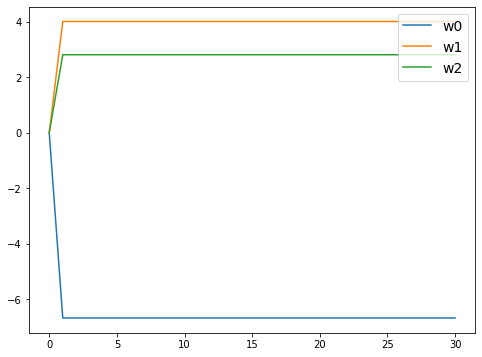

In [8]:
paramhist.plot(figsize=(8, 6)).legend(loc=1, fontsize=14)

**[04PT-10]**

先ほどよりも分散が大きく、分類な困難なトレーニングセットを用意します。

In [9]:
train_set = prepare_dataset(20, [15,10], 35, 30, [0,0], 35)

**[04PT-11]**

学習処理を実行して、結果をグラフに表示します。

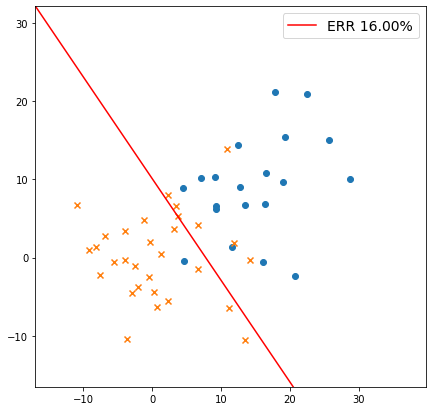

In [10]:
paramhist, err_rate = run_train(train_set)
fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
params = paramhist[-1:]
w0, w1, w2 = float(params.w0), float(params.w1), float(params.w2)
show_result(subplot, train_set, w0, w1, w2, err_rate)

**[04PT-12]**

同じく、パラメーターの変化をグラフに表示します。

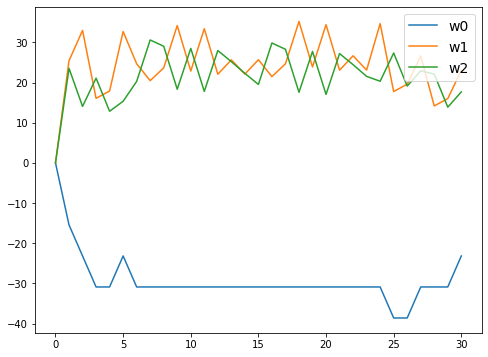

In [11]:
paramhist.plot(figsize=(8, 6)).legend(loc=1, fontsize=14)